In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt


In [5]:
mat_data = sio.loadmat("/workspaces/deeprte/data/matlab/1013/train_delta_1.mat")

In [13]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ct', 'omega', 'omega_prime', 'phi', 'psi_bc', 'psi_label', 'r', 'rv', 'rv_prime', 'sigma_a', 'sigma_t', 'st', 'w_angle', 'x', 'y'])

In [15]:
for k in mat_data:
    print(f"{k}: {np.asarray(mat_data[k]).shape}")

__header__: ()
__version__: ()
__globals__: (0,)
ct: (24, 1)
omega: (24, 1)
omega_prime: (160, 12)
phi: (500, 40, 40)
psi_bc: (500, 160, 12)
psi_label: (500, 40, 40, 24)
r: (40, 40, 2)
rv: (40, 40, 24, 4)
rv_prime: (160, 12, 4)
sigma_a: (500, 40, 40)
sigma_t: (500, 40, 40)
st: (24, 1)
w_angle: (24, 1)
x: (1, 40)
y: (1, 40)


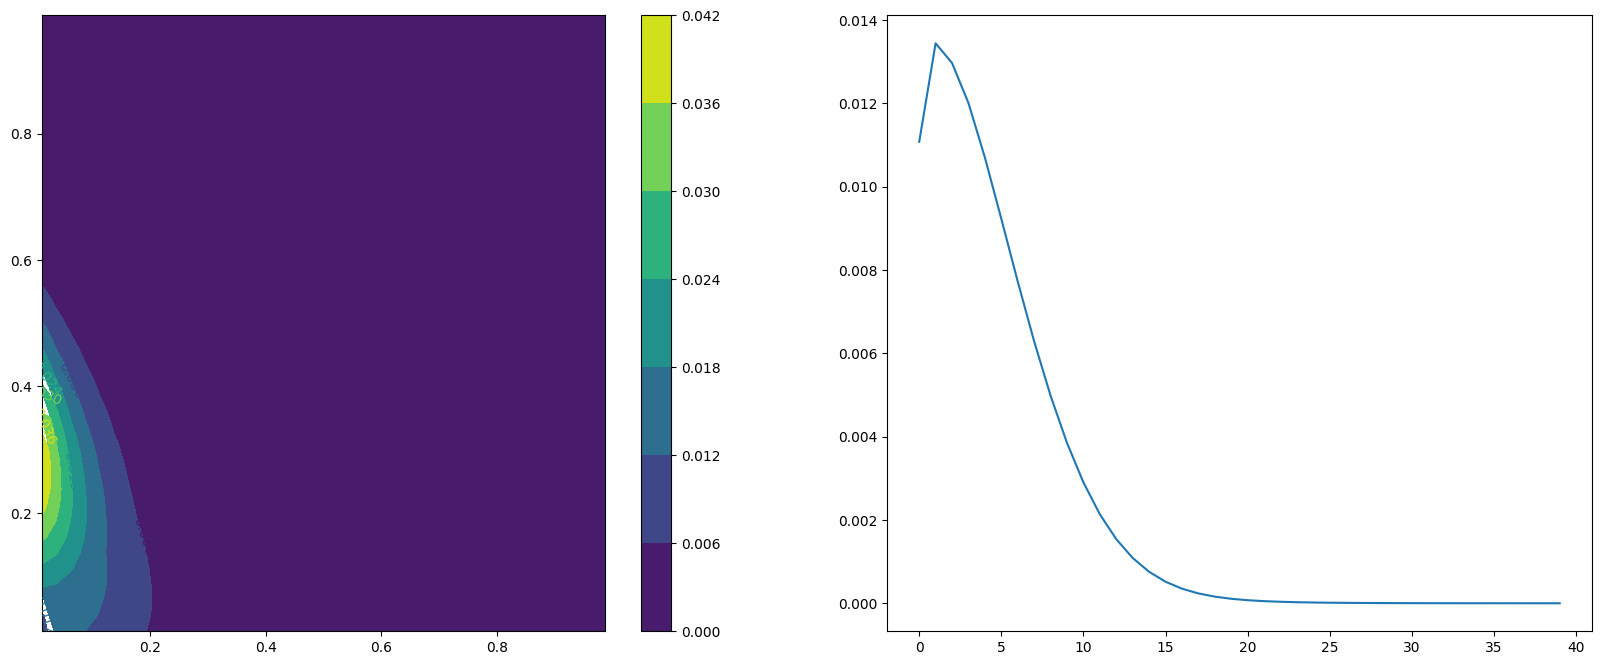

In [64]:
import matplotlib.pyplot as plt

idx = 0

phi = mat_data["phi"][idx]
r = mat_data["r"]

fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

cs = axs[0].contourf(
    r[..., 0],
    r[..., 1],
    phi,
)
axs[0].clabel(cs, inline=True, fontsize=10)
fig.colorbar(cs, ax=axs[0])

axs[1].plot(
    phi[:, 0],
)

plt.show()


## Data

- phi: [B, I, J]
- psi: [B, I, J, M] # [2000, 40, 40, 24]
- rv: [I, J, M, 4]

- psi_bc: [B, 2*(I'+J'), M/2]
- rv_prime: [2*(I'+J'), M/2, 4] # [...., 0]: x, [..., 1]: y, [..., 2]: vx, [..., 3]: vy
- omega: [2*(I'+J'), M/2]

- sigma_*: [B, I, J]
- r: [I, J, 2]

## Grid

- ct, st: [M, 1]
- omega: [M]
- x, y: [I], [J]
- x_prime, y_prime: [I'], [J']



In [18]:
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
from deeprte.dataset import (
    Split,
    load,
    get_nest_dict_shape,
    preprocess_grid,
    _load_and_split_dataset,
    _shard
)


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from deeprte.utils import flat_dict_to_rte_data

dataset = np.load(DATA_DIR / "square_full_1.npz")

dataset = flat_dict_to_rte_data(dataset)

print(tf.nest.map_structure(lambda x: x.shape, dict(dataset)))


{'data': {'sigma_t': (2000, 40, 40), 'sigma_a': (2000, 40, 40), 'psi_label': (2000, 40, 40, 24), 'phi': (2000, 40, 40), 'psi_bc': (2000, 160, 12)}, 'grid': {'r': (40, 40, 2), 'v': (24, 2), 'w_angle': (24,), 'rv_prime': (160, 12, 4), 'w_prime': (160, 12)}}


In [5]:
import matplotlib.pyplot as plt

data, grid = dataset["data"], dataset["grid"]

idx = np.random.randint(500)

# pred_rho = pred_rho.reshape(-1, 40, 40).squeeze()
phi = data["phi"]
r = grid["r"]


# fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
# fig.subplots_adjust(hspace=0.3)
# axs = _axs.flatten()

fig = px.density_contour(phi[idx])
# fig.show()

# cs = axs[0].contourf(
#     r[..., 0],
#     r[..., 1],
#     phi[idx],
# )
# axs[0].clabel(cs, inline=True, fontsize=10)
# fig.colorbar(cs, ax=axs[0])

# axs[1].plot(
#     phi[idx, 0],
# )

# plt.show()


NameError: name 'px' is not defined

In [ ]:
import time

i = np.random.randint(500)


data, grid = flat_dict_to_rte_data(dataset)

data_i = tf.nest.map_structure(lambda x: x[i : i + 1].reshape(1, -1), data)

psi_bc = data_i["psi_bc"]
sigma = np.stack([data_i["sigma_t"], data_i["sigma_a"]], axis=-1)
r, v, rv_prime, w_prime, w_angle = (
    grid["r"],
    grid["v"],
    grid["rv_prime"],
    grid["w_prime"],
    grid["w_angle"],
)

t_prev = time.time()
pred_rho = sol.rho(
    params, None, r, F(r, sigma), F(rv_prime, w_prime * psi_bc), (v, w_angle)
)
pred_rho.block_until_ready()
dt = time.time() - t_prev

print(dt)


In [6]:
ds = load(
    DATA_DIR / "test_square_full.npz",
    Split.VALID,
    is_training=False,
    batch_sizes=[jax.local_device_count(), 3],
    collocation_sizes=None,
    repeat=None,
)

# init_inputs = load_dummy_data(
#     DATA_DIR / "rte_2d_converted.npz", Split.TRAIN_AND_VALID, device_count=5
# )

# get_nest_dict_shape(init_inputs)


In [7]:
for i, d in enumerate(ds):
    if i <= 5:
        print(get_nest_dict_shape(d))
    else:
        break


{'inputs': ((8, 38400, 2), (8, 38400, 2), FunctionInputs(x=(8, 1600, 2), f=(8, 3, 1600, 2)), FunctionInputs(x=(8, 1920, 4), f=(8, 3, 1920))), 'labels': (8, 3, 38400)}
{'inputs': ((8, 38400, 2), (8, 38400, 2), FunctionInputs(x=(8, 1600, 2), f=(8, 3, 1600, 2)), FunctionInputs(x=(8, 1920, 4), f=(8, 3, 1920))), 'labels': (8, 3, 38400)}
{'inputs': ((8, 38400, 2), (8, 38400, 2), FunctionInputs(x=(8, 1600, 2), f=(8, 3, 1600, 2)), FunctionInputs(x=(8, 1920, 4), f=(8, 3, 1920))), 'labels': (8, 3, 38400)}
{'inputs': ((8, 38400, 2), (8, 38400, 2), FunctionInputs(x=(8, 1600, 2), f=(8, 3, 1600, 2)), FunctionInputs(x=(8, 1920, 4), f=(8, 3, 1920))), 'labels': (8, 3, 38400)}
{'inputs': ((8, 38400, 2), (8, 38400, 2), FunctionInputs(x=(8, 1600, 2), f=(8, 3, 1600, 2)), FunctionInputs(x=(8, 1920, 4), f=(8, 3, 1920))), 'labels': (8, 3, 38400)}
{'inputs': ((8, 38400, 2), (8, 38400, 2), FunctionInputs(x=(8, 1600, 2), f=(8, 3, 1600, 2)), FunctionInputs(x=(8, 1920, 4), f=(8, 3, 1920))), 'labels': (8, 3, 38400)

In [ ]:
from deeprte.dataset import get_nest_dict_shape

for d in ds.take(1):
    print(get_nest_dict_shape(d))
    r, v = d["interior"][0], d["interior"][1]
    print(np.sum((r[1] - r[0]) ** 2))
    print(np.sum((v[1] - v[0]) ** 2))


In [1]:
import numpy as np
from deeprte import utils
from deeprte.dataset import get_nest_dict_shape


dataset = np.load("../data/train/square_full_1.npz")
rte_dataset = utils.flat_dict_to_rte_data(dataset)


In [2]:
get_nest_dict_shape(rte_dataset)

{'data': {'sigma_t': (2000, 40, 40),
  'sigma_a': (2000, 40, 40),
  'psi_label': (2000, 40, 40, 24),
  'phi': (2000, 40, 40),
  'psi_bc': (2000, 160, 12)},
 'grid': {'r': (40, 40, 2),
  'v': (24, 2),
  'w_angle': (24,),
  'rv_prime': (160, 12, 4),
  'w_prime': (160, 12)}}

In [3]:
rte_dataset["data"]["psi_bc"] *= 5.0
rte_dataset["data"]["psi_label"] *= 5.0


In [4]:
np.savez("../data/train/fake.npz", **utils.to_flat_dict(rte_dataset, sep="/"))

In [3]:
fake = np.load("../data/train/fake.npz")
fake_ds = utils.flat_dict_to_rte_data(fake)

In [6]:
np.mean((fake_ds["data"]["psi_label"] - 5 * rte_dataset["data"]["psi_label"])**2)

0.0

In [7]:
get_nest_dict_shape(fake_ds)

{'data': {'sigma_t': (2000, 40, 40),
  'sigma_a': (2000, 40, 40),
  'psi_label': (2000, 40, 40, 24),
  'phi': (2000, 40, 40),
  'psi_bc': (2000, 160, 12)},
 'grid': {'r': (40, 40, 2),
  'v': (24, 2),
  'w_angle': (24,),
  'rv_prime': (160, 12, 4),
  'w_prime': (160, 12)}}